In [1]:
pip install numpy matplotlib networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math 



In [15]:
#aim is to learn the scores vector without knowing it from beforehand

# Simulate pairwise comparison outcomes using the BTL model
def simulate_btl_model(n_items, scores, num_comparisons=10):
    comparisons = np.zeros((n_items, n_items))
    for i in range(n_items):
        for j in range(i + 1, n_items):
            prob_j_wins = scores[j] / (scores[i] + scores[j])
            wins_j = np.random.binomial(num_comparisons, prob_j_wins)
            comparisons[i, j] = wins_j
            comparisons[j, i] = num_comparisons - wins_j
    return comparisons

def simulate_btl_model_soft(n_items, scores, num_comparisons=10):
    comparisons = np.zeros((n_items, n_items))
    for i in range(n_items):
        for j in range(i + 1, n_items):
            #using softmax instead of simple fractions
            prob_j_wins = math.exp(scores[j]) / (math.exp(scores[i]) + math.exp(scores[j]))
            wins_j = np.random.binomial(num_comparisons, prob_j_wins)
            comparisons[i, j] = wins_j
            comparisons[j, i] = num_comparisons - wins_j
    return comparisons

# Construct the comparison graph
def construct_comparison_graph(comparisons):
    G = nx.DiGraph()
    n_items = comparisons.shape[0]
    for i in range(n_items):
        for j in range(n_items):
            if i != j and comparisons[i, j] > 0:
                weight = comparisons[i, j] / (comparisons[i, j] + comparisons[j, i])
                G.add_edge(i, j, weight=weight)
    return G

In [3]:
# Compute spectral gap
def compute_spectral_gap(G):
    laplacian = nx.normalized_laplacian_matrix(G).toarray()
    eigenvalues = np.linalg.eigvalsh(laplacian)
    eigenvalues.sort()
    spectral_gap = eigenvalues[1]  # λ2 for normalized Laplacian
    return spectral_gap

# Visualization

def visualize_graph(G):
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, connectionstyle="arc3,rad=0.2")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.show()

In [4]:
# Compute spectral gap
def compute_spectral_gap(G):
    laplacian = nx.normalized_laplacian_matrix(G).toarray()
    eigenvalues = np.linalg.eigvalsh(laplacian)
    eigenvalues.sort()
    #print(eigenvalues)
    spectral_gap = eigenvalues[1]  # λ2 for normalized Laplacian
    return spectral_gap

# Perform the random walk and compute the stationary distribution
def compute_stationary_distribution(G):
    # Transition matrix
    max_out_degree = max(dict(G.out_degree()).values())
    n = G.number_of_nodes()
    comparison_graph = nx.to_numpy_array(G, weight="weight")
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                P[i][j] = (comparison_graph[i][j])/((comparison_graph[i][j]+comparison_graph[j][i])*max_out_degree)
    
    for i in range(n):
        P[i][i] = 1 - sum([P[i][j] for j in range(n)])

    #print('emperical transition matrix')
    #print(P)

    # Find eigenvector corresponding to eigenvalue 1 of P
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    #print('eigenvalues :',eigenvalues)
  
    stationary_vector = np.array(eigenvectors[:, np.isclose(eigenvalues, 1)])
    #print('stationary vector:', stationary_vector)
    stationary_vector = stationary_vector[:, 0]
    stationary_vector = stationary_vector / stationary_vector.sum()  # Normalize
    return stationary_vector

def ideal_stationary_distribution(scores):
    score_total = sum(scores)
    scores = np.array(scores)
    normalised = [score/score_total for score in scores]
    return [float(val) for val in normalised]    


In [82]:
# Main
n_items = 20
true_scores = np.random.rand(n_items)
print('true scores:',true_scores)

true_scores_normalised = [x/true_scores.sum() for x in true_scores]
comparisons = simulate_btl_model(n_items, true_scores_normalised, 10)
G = construct_comparison_graph(comparisons)
spectral_gap = compute_spectral_gap(G)
stationary_distribution = compute_stationary_distribution(G)
actual_stationary_distribution = ideal_stationary_distribution(true_scores_normalised)

# Calculate the error between the stationary distribution and the actual stationary distribution
error = np.linalg.norm(np.array(stationary_distribution) - np.array(actual_stationary_distribution))/ np.linalg.norm(np.array(actual_stationary_distribution))
print("Error between stationary distribution and actual stationary distribution:", error)

# Output results
#print("Comparison Matrix:\n", comparisons)
#print("Spectral Gap:", spectral_gap)
print("Stationary Distribution:", stationary_distribution)
print('Actual stationary distribution:', actual_stationary_distribution)




# Visualize the graph
#visualize_graph(G)

true scores: [0.35701981 0.05879536 0.48187978 0.78639835 0.76775453 0.51813687
 0.0602771  0.14154077 0.916153   0.90313504 0.33962764 0.13938533
 0.28664082 0.98907988 0.82179198 0.55525161 0.9684033  0.91098475
 0.38215781 0.3194949 ]
[-0.179723    0.80126424  0.92858545  0.94988023  0.95945779  0.98194964
  0.99509344  1.01041589  1.04003106  1.04822544  1.05930276  1.08377772
  1.09051808  1.11938932  1.12821965  1.13014662  1.1705438   1.1991918
  1.21512567  1.26860441]
emperical transition matrix
eigenvalues : [1.        +0.j         0.10635295+0.j         0.14023611+0.j
 0.24973339+0.j         0.27069397+0.j         0.36161349+0.j
 0.40479526+0.j         0.45385023+0.j         0.48968141+0.01299462j
 0.48968141-0.01299462j 0.53397006+0.01115898j 0.53397006-0.01115898j
 0.66141821+0.j         0.65356157+0.j         0.63604337+0.02275161j
 0.63604337-0.02275161j 0.57257987+0.j         0.60211141+0.01744718j
 0.60211141-0.01744718j 0.60155243+0.j        ]
stationary vector: [[-0.

In [12]:
# Number of instances
num_instances = 100
errors = []
errors_soft = []
n_items = 20

for _ in range(num_instances):
    true_scores = np.random.rand(n_items)
    true_scores_normalised = [x/true_scores.sum() for x in true_scores]
    comparisons = simulate_btl_model(n_items, true_scores_normalised, 100)
    G = construct_comparison_graph(comparisons)
    spectral_gap = compute_spectral_gap(G)
    stationary_distribution = compute_stationary_distribution(G)
    actual_stationary_distribution = ideal_stationary_distribution(true_scores_normalised)

    comparisons_soft = simulate_btl_model_soft(n_items, true_scores_normalised, 100)
    G = construct_comparison_graph(comparisons_soft)
    spectral_gap = compute_spectral_gap(G)
    stationary_distribution_soft = compute_stationary_distribution(G)

    # Calculate the error between the stationary distribution and the actual stationary distribution
    error = np.linalg.norm(np.array(stationary_distribution) - np.array(actual_stationary_distribution)) / np.linalg.norm(np.array(actual_stationary_distribution))
    error_soft = np.linalg.norm(np.array(stationary_distribution_soft) - np.array(actual_stationary_distribution)) / np.linalg.norm(np.array(actual_stationary_distribution))
    errors.append(error)
    errors_soft.append(error_soft)

# Compute the average error
average_error = np.mean(errors)
average_error_soft = np.mean(errors_soft)
print("Average Error between stationary distribution and actual stationary distribution over multiple instances:", average_error)
print("Average Error between stationary distribution and actual stationary distribution over multiple instances (soft):", average_error_soft)

Average Error between stationary distribution and actual stationary distribution over multiple instances: 0.08570180988569122
Average Error between stationary distribution and actual stationary distribution over multiple instances (soft): 0.4734380715089515


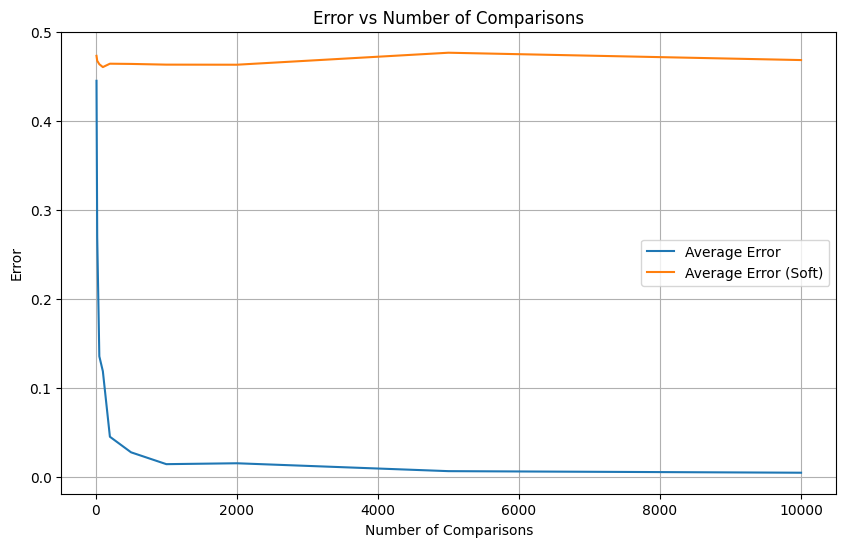

In [16]:
# Vary the number of comparisons
comparison_counts = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
average_errors = []
average_errors_soft = []

for num_comparisons in comparison_counts:
    errors = []
    errors_soft = []
    for _ in range(num_instances):
        true_scores = np.random.rand(n_items)
        true_scores_normalised = [x/true_scores.sum() for x in true_scores]
        
        comparisons = simulate_btl_model(n_items, true_scores_normalised, num_comparisons)
        G = construct_comparison_graph(comparisons)
        stationary_distribution = compute_stationary_distribution(G)
        actual_stationary_distribution = ideal_stationary_distribution(true_scores_normalised)
        
        comparisons_soft = simulate_btl_model_soft(n_items, true_scores_normalised, num_comparisons)
        G_ = construct_comparison_graph(comparisons_soft)
        stationary_distribution_soft = compute_stationary_distribution(G_)
        
        error = np.linalg.norm(np.array(stationary_distribution) - np.array(actual_stationary_distribution)) / np.linalg.norm(np.array(actual_stationary_distribution))
        error_soft = np.linalg.norm(np.array(stationary_distribution_soft) - np.array(actual_stationary_distribution)) / np.linalg.norm(np.array(actual_stationary_distribution))
        
        errors.append(error)
        errors_soft.append(error_soft)
    
    average_errors.append(np.mean(errors))
    average_errors_soft.append(np.mean(errors_soft))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(comparison_counts, average_errors, label='Average Error')
plt.plot(comparison_counts, average_errors_soft, label='Average Error (Soft)')
plt.xlabel('Number of Comparisons')
plt.ylabel('Error')
plt.title('Error vs Number of Comparisons')
plt.legend()
plt.grid(True)
plt.show()

Quite interesting to see that using softmax, the random walk interpretation doesnt converge at all
